In [11]:
import jax
import jax.numpy as jnp
import flax
import optax
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

# DARTS: DIFFERENTIABLE ARCHITECTURE SEARCH

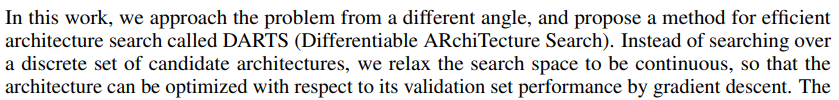

$w$ - weights of the model (in classical sense)

$\alpha$ - parameters of the model, describing the architecture (see MetaLayer class to understand how, also check out this screenshot from paper)
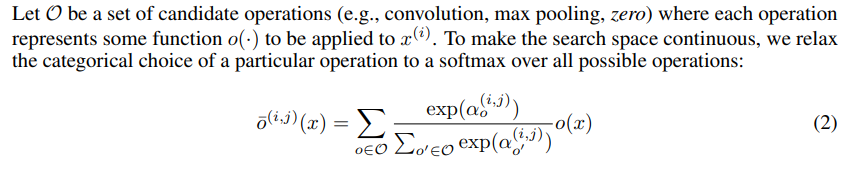

## How to train
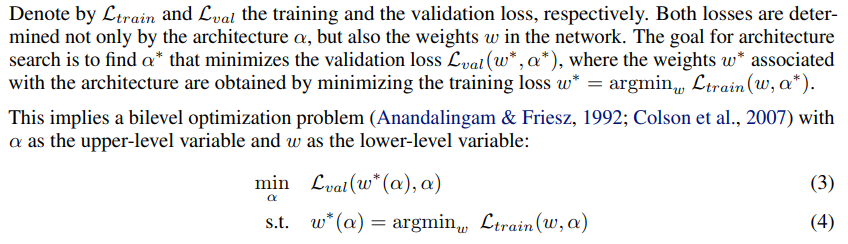
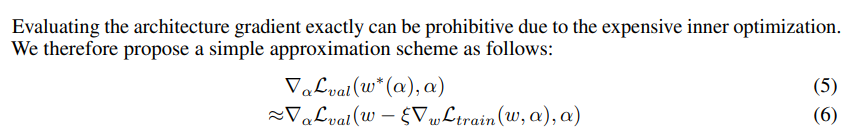

### How optimizer step works
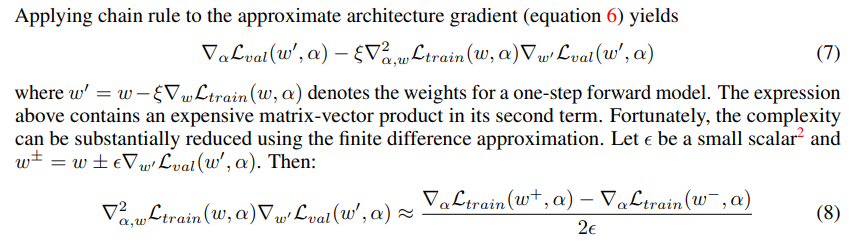

In [12]:
class NoPar:
    """Layer that doesn't have differentiable parameters"""
    def init(self, k: jax.random.PRNGKey, x: jax.Array) -> dict:
        return None

class MaxPool2D(NoPar):
    def __init__(self, kernel_size=(3,3)) -> None:
        self.kernel_size = kernel_size
    
    def apply(self, par: None, x: jax.Array) -> jax.Array:
        return flax.linen.max_pool(x, self.kernel_size, padding='SAME')

class AvgPool2D(NoPar):
    def __init__(self, kernel_size=(3,3)) -> None:
        self.kernel_size = kernel_size
    
    def apply(self, par: None, x: jax.Array) -> jax.Array:
        return flax.linen.avg_pool(x, self.kernel_size, padding='SAME')

class Identity(NoPar):
    def apply(self, par: None, x: jax.Array) -> jax.Array:
        return x

class Zero(NoPar):
    def apply(self, par: None, x: jax.Array) -> jax.Array:
        return jnp.zeros_like(x)

class MetaLayer(flax.linen.Module):
    """""MetaLayer class for implementing a layer with ambiguous architacture.

    A value is got by adding weighted values of possible layer types:

    Conv2D 2x2 and 3x3,
    MaxPool2D 2x2 and 3x3
    AvgPool2D 2x2 and 3x3,
    Identity,
    Zero
    """""

    def __init__(self) -> None:
        self.sublayers = [flax.linen.Conv(features=3, kernel_size=(3,3)),
                          flax.linen.Conv(features=3, kernel_size=(5,5)),
                          MaxPool2D(kernel_size=(3,3)),
                          MaxPool2D(kernel_size=(5,5)),
                          AvgPool2D(kernel_size=(3,3)),
                          AvgPool2D(kernel_size=(5,5)),
                          Identity(),
                          Zero()]
        self.batch_norm = flax.linen.BatchNorm
        
    def init(self, key: jax.random.PRNGKey, x: jax.Array) -> dict:
        ks = jax.random.split(key, len(self.sublayers))
        return [layer.init(k, x) for k, layer in zip(ks, self.sublayers)]
    
    def alphas(self, key: jax.random.PRNGKey) -> jax.Array:
        return jax.random.uniform(key, (8,))
    
    def apply(self, pars: list, alpha: jax.Array, x: jax.Array) -> jax.Array:
        res = []
        for par, layer in zip(pars, self.sublayers):
            res.append(layer.apply(par, x))
        weights = jnp.exp(-alpha).reshape(-1, *([1]*x.ndim))
        return (weights * jnp.asarray(res) / weights.sum()).sum(axis=0)

In [16]:
class DARTS(flax.linen.Module):
    """This class implements DARTS network with three layers"""
    def __init__(self) -> None:
        self.layers = [
            MetaLayer(),
            MetaLayer(),
            MetaLayer(),
        ]
        self.dense = flax.linen.Dense(features=10)
    
    def init(self, key: jax.random.PRNGKey, x: jax.Array) -> dict:
        ks = jax.random.split(key, len(self.layers))
        pars = [layer.init(k, x) for k, layer in zip(ks, self.layers)]
        pars.append(self.dense.init(ks[-1], x.reshape(x.shape[0], -1)))
        return pars
    
    def alphas(self, key: jax.random.PRNGKey) -> jax.Array:
        ks = jax.random.split(key, len(self.layers))
        return [layer.alphas(k) for k, layer in zip(ks, self.layers)]
    
    def apply(self, pars: list, alphas: list, x: jax.Array) -> jax.Array:
        for par, alpha, layer in zip(pars, alphas, self.layers):
            x = layer.apply(par, alpha, x)
        x = self.dense.apply(pars[-1], x.reshape(x.shape[0], -1))
        return jax.nn.softmax(x)

In [17]:
def mul_dict(d, a):
    if type(d) == dict:
        return {k : mul_dict(v, a) for k, v in d.items()}
    elif type(d) == list:
        return [mul_dict(v, a) for v in d]
    elif d is None:
        return None
    else:
        return d*a

def add_dict(d1, d2):
    assert type(d1) == type(d2)
    if type(d1) == dict:
        ans = {}
        for k in d1.keys():
            ans[k] = add_dict(d1[k], d2[k])
        return ans
    elif type(d1) == list:
        return [add_dict(v1, v2) for v1, v2 in zip(d1, d2)]
    elif d1 is None:
        return None
    else:
        return d1 + d2

class DARTSOptimiser:
    def __init__(self, xi=1e-3, eps=1e-4) -> None:
        self.xi = xi
        self.eps = eps
    
    def init(self, params: dict, alpha: dict) -> None:
        self.w = params
        self.a = alpha
    
    def grad_a(self, model: DARTS, w: dict, xs: jax.Array, ys: jax.Array):
        def loss(a: dict) -> float:
            pred = model.apply(w, a, xs)
            return optax.softmax_cross_entropy_with_integer_labels(pred, ys).mean()
        return jax.grad(loss)
    
    def grad_w(self, model: DARTS, a: dict, xs: jax.Array, ys: jax.Array):
        def loss(w: dict) -> float:
            pred = model.apply(w, a, xs)
            return optax.softmax_cross_entropy_with_integer_labels(pred, ys).mean()
        return jax.grad(loss)
    
    def loss(self, model: DARTS, xs: jax.Array, ys: jax.Array) -> float:
        pred = model.apply(self.w, self.a, xs)
        return optax.softmax_cross_entropy_with_integer_labels(pred, ys).mean()
    
    def acc(self, model: DARTS, xs: jax.Array, ys: jax.Array) -> float:
        pred = model.apply(self.w, self.a, xs)
        return (jnp.argmax(pred, axis=1) == ys).mean()
    
    def step(self, model: DARTS, 
             batch_train: tuple[jax.Array], 
             batch_val: tuple[jax.Array]):
        grad_wtrain = self.grad_w(model, self.a, *batch_train)
        # wprime = self.w - self.xi * grad_wtrain(self.w)
        wprime = add_dict(self.w, mul_dict(grad_wtrain(self.w), -self.xi))
        grad_wval = self.grad_w(model, self.a, *batch_val)
        wprime_grad = grad_wval(wprime)
        # wplus = self.w + self.eps * wprime_grad
        wplus = add_dict(self.w, mul_dict(wprime_grad, self.eps))
        # wminus = self.w - self.eps * wprime_grad
        wminus = add_dict(self.w, mul_dict(wprime_grad, -self.eps))
        grad_alpha_train_plus = self.grad_a(model, wplus, *batch_train)
        aplus = grad_alpha_train_plus(self.a)
        grad_alpha_train_minus = self.grad_a(model, wminus, *batch_train)
        aminus = grad_alpha_train_minus(self.a)
        self.a = mul_dict(add_dict(aplus, mul_dict(aminus, -1)), 0.5/self.eps)
        self.w = wprime

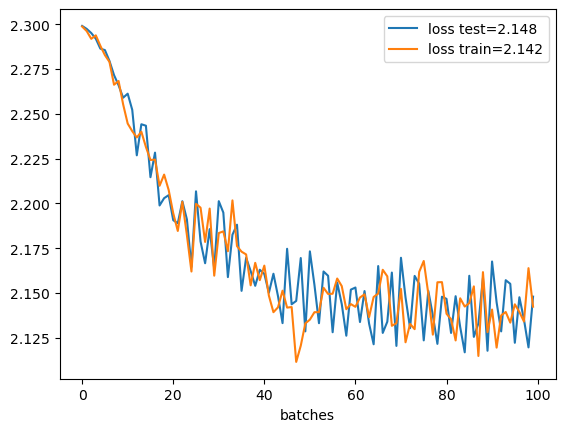

In [18]:
def norm(x):
    return x / 128 - 1

BATCH_SIZE = 500
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = norm(jnp.asarray(jnp.split(x_train, x_train.shape[0]//BATCH_SIZE, 0)))
x_test  = norm(jnp.asarray(jnp.split(x_test,  x_test.shape[0] //BATCH_SIZE, 0)))
y_train = jnp.asarray(jnp.split(y_train[:, 0], y_train.shape[0]//BATCH_SIZE, 0))
y_test  = jnp.asarray(jnp.split(y_test[:, 0],  y_test.shape[0] //BATCH_SIZE, 0))
x_train, x_val = x_train[:int(len(x_train)*0.8)], x_train[int(len(x_train)*0.8):]
y_train, y_val = y_train[:int(len(y_train)*0.8)], y_train[int(len(y_train)*0.8):]

key = jax.random.PRNGKey(1)
k1 = key.copy()
model = DARTS()
params = model.init(key, x_train[0]) # init with first batch to calculate shapes for params
alphas = model.alphas(key)

opt = DARTSOptimiser(xi=1.0, eps=1.0)
opt.init(params, alphas)

xis = jnp.asarray([1.0]*25 + [0.5]*25 + [0.1]*25 + [0.05]*25)
epss = xis
loss_test = []
loss_train = []
accs = []
for i, (xi, eps) in enumerate(zip(xis, epss)):
    opt.xi = xi
    opt.eps = eps
    opt.step(model, (x_train[i%len(x_train)], y_train[i%len(y_train)]), 
                    (x_val[i%len(x_val)], y_val[i%len(y_val)]))
    loss_test.append(opt.loss(model, x_test[i%len(x_test)], y_test[i%len(y_test)]))
    loss_train.append(opt.loss(model, x_train[i%len(x_train)], y_train[i%len(x_train)]))
    accs.append(opt.acc(model, x_test[i%len(x_test)], y_test[i%len(y_test)]))
    clear_output()
    plt.plot(loss_test, label=f'loss test={loss_test[-1]:.3f}')
    plt.plot(loss_train, label=f'loss train={loss_train[-1]:.3f}')
    # plt.plot(accs, label=f'accuracy test={accs[-1]:.3f}')
    plt.xlabel('batches')
    plt.legend()
    plt.show()

In [25]:
print('Resulting accuracy on test:',\
      jnp.mean(jnp.asarray([opt.acc(model, *batch) for batch in zip(x_test, y_test)])))

Resulting accuracy on test: 0.32250002


Not great, but better than random!

In [ ]:
alphas

[Array([0.9031066 , 0.9599736 , 0.71778095, 0.9052192 , 0.59257615,
        0.03765273, 0.23912036, 0.5959858 ], dtype=float32),
 Array([0.62871623, 0.8493314 , 0.8554791 , 0.4876157 , 0.28242314,
        0.95538616, 0.2683488 , 0.77650356], dtype=float32),
 Array([0.02993441, 0.60867953, 0.52837336, 0.07641912, 0.3859141 ,
        0.2654171 , 0.8094001 , 0.70675385], dtype=float32)]

As you can see, we haven't arrived to a discrete architecture like show on this picture. Maybe it would've happened given enough time.
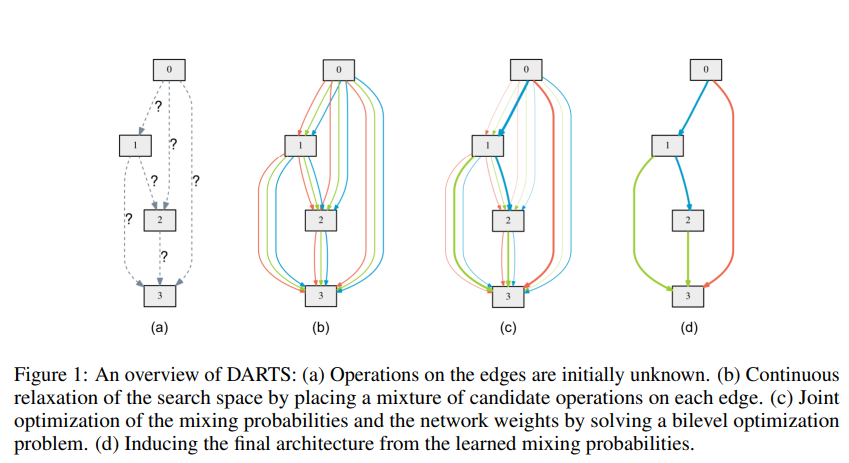
